# 2.4 Trial barcoding

In [1]:
prefix = '/home/ines/repositories/'
# prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [2]:

""" 
IMPORTS
"""
import os
import numpy as np
import seaborn as sns
from collections import defaultdict
import pandas as pd
import pickle
import random

from one.api import ONE
from pprint import pprint
import matplotlib.pyplot as plt
from scipy.stats import mode

# --Machine learning and statistics
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance_matrix, distance
from matplotlib.colors import ListedColormap, to_rgb, to_hex

# Get my functions
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//2_fit_models/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from postprocessing_functions import  define_trial_types, rescale_sequence
os.chdir(functions_path)
from plotting_functions import plot_binned_sequence # , plot_barcode
functions_path =  prefix + 'representation_learning_variability/Functions/'
os.chdir(functions_path)
from data_processing import save_and_log
one = ONE(mode='remote')

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/one/alf/files.py:10: FutureWarning: `one.alf.files` will be removed in version 3.0. Use `one.alf.path` instead.
  warnings.warn(


## Parameters

In [3]:
# Parameters
bin_size = 0.017
num_states = 2
threshold = 0
optimal_k = 4

save_path = prefix + 'representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'

# LOAD DATA
data_path = prefix + 'representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v5_15Jan2025/' + str(bin_size) + '/'
all_files = os.listdir(data_path)
design_matrices = [item for item in all_files if 'design_matrix' in item and 'standardized' not in item]
idxs, mouse_names = idxs_from_files(design_matrices, bin_size)

states_path =  prefix + 'representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'
wavelet_states_path = prefix +  'representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/wavelet_transform_states/'

path_sets = [wavelet_states_path, states_path, states_path]


# Individual sessions

In [4]:
# Identify sessions available to process
sessions_to_process = []
for m, mat in enumerate(idxs):
    mouse_name = mat[37:]
    session = mat[:36]
    fit_id = str(mouse_name + session)
    whisker_filename = os.path.join(states_path, "most_likely_states" + 'whisker_me' + '_' + fit_id)
    licks_filename = os.path.join(states_path, "most_likely_states" + 'Lick count' + '_' + fit_id)
    wavelet_filename = os.path.join(wavelet_states_path, "most_likely_states_" + str(optimal_k) + '_' + fit_id)

    if os.path.exists(whisker_filename) and os.path.exists(licks_filename) and os.path.exists(wavelet_filename):
        sessions_to_process.append((mouse_name, session))

print(f"Found {len(sessions_to_process)} sessions to process.")

Found 215 sessions to process.


## Get sequences per trial epoch

In [5]:
# Load preprocessed data
results_path = prefix + 'representation_learning_variability/Models/Sub-trial/3_postprocess_results/'
filename_states = str(results_path + 'states_trial_type03-11-2025')
states_file = pd.read_parquet(filename_states, engine='pyarrow')

In [6]:
# Load trial clsuters
results_path = prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/'
filename = str(results_path + 'cluster_per_trial_no_timing03-19-2025')
trial_clusters = pd.read_parquet(filename, engine='pyarrow')

In [7]:
trial_clusters_reduced = trial_clusters[['mouse_name', 'session', 'trial_id', 'cluster']]
trial_clusters_reduced['trial_id'] = trial_clusters_reduced['trial_id'].astype(float)

states_df = states_file.merge(trial_clusters_reduced, on=['mouse_name', 'session', 'trial_id'])

/tmp/ipykernel_5558/1596362958.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trial_clusters_reduced['trial_id'] = trial_clusters_reduced['trial_id'].astype(float)


In [8]:
wheel_mapping = {'000': 3.0,
           '100': 0.0,
           '200': 1.0,
           '300': 2.0,
           '010': 3.0,
           '110': 0.0,
           '210': 1.0,
           '310': 2.0,
           '001': 3.0,
           '101': 0.0,
           '201': 1.0,
           '301': 2.0, 
           '011': 3.0,
           '111': 0.0,
           '211': 1.0,
           '311': 2.0,
           'nan': np.nan
           }


wheel_func = np.vectorize(wheel_mapping.get)
states_df['wheel_states'] = wheel_func(states_df['identifiable_states'])

fix_mapping = {0.0: 3.0,
           1.0: 0.0,
           2.0: 1.0,
           3.0: 2.0,
           4.0: 7.0,
           5.0: 4.0,
           6.0: 5.0,
           7.0: 6.0,
           8.0: 11.0,
           9.0: 8.0,
           10.0: 9.0,
           11.0: 10.0,
           12.0: 15.0,
           13.0: 12.0,
           14.0: 13.0,
           15.0: 14.0,
           'nan': np.nan
           }
fix_func = np.vectorize(fix_mapping.get)
states_df['most_likely_states'] = fix_func(states_df['most_likely_states'])

In [48]:

def create_grouped_gradient_palette(n_groups=4, shades_per_group=4, base_palette='tab10'):
    # Pick n_groups distinct colors from base palette
    base_colors = sns.color_palette(base_palette, n_colors=n_groups)
    
    # Function to generate shades for a given color
    def generate_shades(color, n_shades):
        color_rgb = np.array(to_rgb(color))
        # Create shades by interpolating towards white (lighter) or black (darker)
        factors = np.linspace(0.4, 1.0, n_shades)  # You can adjust range for more/less contrast
        return [to_hex(color_rgb * factor + (1 - factor)) for factor in factors]
    
    # Build full palette
    full_palette = []
    for color in base_colors:
        shades = generate_shades(color, shades_per_group)
        full_palette.extend(shades)
    
    return ListedColormap(full_palette)

palette_16 = create_grouped_gradient_palette(n_groups=4, shades_per_group=4, base_palette='tab10')


import numpy as np
from scipy.interpolate import interp1d

def rescale_timeseries(timeseries, target_length, kind='linear'):
    """
    Rescale a 1D time series to a new length via interpolation.

    Parameters:
    - timeseries (array-like): Original time series (1D).
    - new_length (int): Desired number of points in rescaled time series.
    - kind (str): Type of interpolation ('linear', 'nearest', 'cubic', etc.)

    Returns:
    - np.ndarray: Rescaled time series of length `new_length`.
    """
    timeseries = np.asarray(timeseries)
    original_length = len(timeseries)

    if original_length == target_length:
        return timeseries.copy()        
        
    x_original = np.linspace(0, 1, original_length)
    x_new = np.linspace(0, 1, target_length)

    if original_length == 1:
        temp = [timeseries.copy()] * target_length
        temp = np.array(temp).ravel()
        return temp
        
    interpolator = interp1d(x_original, timeseries, kind=kind)
    rescaled = interpolator(x_new)

    return rescaled


def plot_barcode(df_grouped, wheel_grouped, plot_trials, states_to_append, palette):
        trials = df_grouped['sample'].unique()
        use_trial_keys = random.sample(list(np.arange(0, len(trials))), plot_trials)
        use_trials = trials[use_trial_keys]
        for t, trial in enumerate(use_trials):
                fig, axs = plt.subplots(1, 4, sharex=False, sharey=True, figsize=(8, 1))

                for e, epoch in enumerate(['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']):
                        epoch_data = df_grouped.loc[(df_grouped['broader_label']==epoch) &
                                                        (df_grouped['sample']==trial)]
                        epoch_sequence = list(epoch_data['binned_sequence'])[0]
                        
                        epoch_wheel = list(wheel_grouped.loc[(wheel_grouped['broader_label']==epoch) &
                                                        (wheel_grouped['sample']==trial), 'binned_wheel'])[0]
                        
                        axs[e].plot(np.arange(.5, len(epoch_wheel)+.5), np.abs(epoch_wheel))
                        axs[e].imshow(np.concatenate([epoch_sequence, states_to_append])[None,:],  
                                extent=(0, len(np.concatenate([epoch_sequence, states_to_append])), 
                                        0, 8),
                                aspect="auto",
                                cmap=palette,
                                alpha=0.8) 
                        axs[e].set_xlim([0.5, len(epoch_sequence)-.5])
                        axs[e].set_ylim([0, 8])
                        axs[e].set_title(epoch)
                        
                plt.show()

## Trial epoch barcoding

In [49]:
trial_type_agg = ['correct_str', 'contrast_str', 'block_str', 'choice']
# trial_type_agg = ['correct_str']

plot = False
target_length = 10
plot_trials = 10  # Trials to plot per session

all_sequences = pd.DataFrame(columns=['mouse_name', 'trial_type', 'broader_label', 'binned_sequence'])
all_wheel = pd.DataFrame(columns=['mouse_name', 'trial_type', 'broader_label', 'binned_wheel'])

for m, mat in enumerate(sessions_to_process):

    # try:
    mouse_name = mat[0]
    session = mat[1]
    fit_id = str(mouse_name+session)

    states_trial = states_df.loc[states_df['session']==session]
    num_states = len(states_df['most_likely_states'].unique())

    """ Define trial types  """
    states_trial = define_trial_types(states_trial, trial_type_agg)
    vars = ['sample', 'trial_type', 'broader_label', 'mouse_name', 'most_likely_states']

    df_grouped = states_trial.groupby(vars[:-1])['most_likely_states'].apply(list).reset_index()
    df_grouped.rename(columns={'most_likely_states': 'sequence'}, inplace=True)
    df_grouped['binned_sequence'] = df_grouped['sequence'].apply(lambda seq: rescale_sequence(seq, target_length))  # New function removed NaNs
    
    wheel_grouped = states_trial.groupby(vars[:-1])['avg_wheel_vel'].apply(list).reset_index()
    wheel_grouped.rename(columns={'avg_wheel_vel': 'wheel_sequence'}, inplace=True)
    wheel_grouped['binned_wheel'] = wheel_grouped['wheel_sequence'].apply(lambda wheel: rescale_timeseries(wheel, target_length))  # New function removed NaNs

    print(mouse_name)
    if plot == True:
        states_to_append = np.arange(0, num_states)
        plot_barcode(df_grouped, wheel_grouped, plot_trials, states_to_append, palette_16)
    # except:
    #     print('Problem with mouse ' + mouse_name)

    all_sequences = pd.concat([all_sequences, df_grouped[['mouse_name', 'sample', 'trial_type', 'broader_label', 'binned_sequence']]], ignore_index=True)
    all_wheel = pd.concat([all_wheel, wheel_grouped[['mouse_name', 'sample', 'trial_type', 'broader_label', 'binned_wheel']]], ignore_index=True)

all_binned = all_sequences.merge(all_wheel[['sample', 'broader_label', 'binned_wheel']], on=['broader_label', 'sample'])

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

ZFM-02372


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

DY_010


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

SWC_054


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

ZFM-01936


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

SWC_043


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

KS096


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

ibl_witten_29


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

NYU-47


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

DY_010


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

CSHL052


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

SWC_054


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

DY_011


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

DY_020


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

SWC_058


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

UCLA037


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

UCLA017


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

ZFM-01592


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

UCLA034


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

ZFM-01936


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

ZFM-01577


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

SWC_054


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

UCLA037


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

SWC_060


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

DY_014


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

CSHL058


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

KS094


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

SWC_052


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

NYU-11


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

ibl_witten_29


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

KS096


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

ZFM-02372


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

CSHL058


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

PL015


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

PL017


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

KS094


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

ZFM-02370


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

NYU-48


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

CSHL059


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

ibl_witten_27


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

ZFM-01577


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

SWC_054


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

KS096


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

ZFM-01577


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

ibl_witten_26


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

DY_020


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

ibl_witten_29


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

SWC_060


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

CSHL060


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

CSH_ZAD_022


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

DY_016


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

CSH_ZAD_026


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

DY_014


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

ibl_witten_27


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

CSHL053


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

UCLA006


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

DY_016


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

KS091


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

CSHL060


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

SWC_061


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

CSHL053


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

KS094


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

UCLA011


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

CSHL053


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

NYU-40


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

NYU-47


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

SWC_043


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

CSHL060


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

DY_016


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

CSHL052


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

ZFM-01937


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

DY_020


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

SWC_061


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

SWC_042


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

CSHL052


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

ZFM-01936


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

ibl_witten_29


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

CSHL059


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

CSH_ZAD_025


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

ZFM-01936


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

CSH_ZAD_022


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

KS094


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

ibl_witten_29


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

PL017


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

ZFM-02370


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

SWC_053


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

ZFM-01935


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

ibl_witten_27


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

CSH_ZAD_019


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

NYU-39


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

UCLA033


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

DY_018


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

UCLA034


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

CSHL060


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

SWC_043


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

PL016


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

ibl_witten_26


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

NYU-39


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

PL015


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

DY_020


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

CSHL049


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

NYU-46


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

CSH_ZAD_024


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

SWC_054


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

NYU-46


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

SWC_039


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

ZFM-02373


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

UCLA034


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

SWC_043


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

SWC_052


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

CSHL045


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

SWC_052


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

UCLA012


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

DY_020


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

DY_016


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

CSH_ZAD_022


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

CSH_ZAD_026


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

DY_013


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

UCLA014


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

ibl_witten_20


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

UCLA037


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

PL017


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

PL017


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

SWC_060


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

PL015


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

KS084


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

CSHL045


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

SWC_043


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

ZFM-01935


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

NR_0020


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

SWC_052


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

DY_020


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

CSHL054


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

ibl_witten_26


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

ibl_witten_26


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

CSH_ZAD_025


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

ibl_witten_29


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

DY_020


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

CSHL053


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

SWC_058


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

CSHL055


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

DY_014


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

ibl_witten_29


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

CSH_ZAD_025


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

ZFM-01576


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

ZFM-02369


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

DY_018


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

UCLA035


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

ZFM-02368


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

CSHL045


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

CSHL060


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

CSHL045


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

NYU-39


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

UCLA036


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

CSHL047


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

CSHL059


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

SWC_061


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

DY_014


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

CSHL059


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

ZFM-01592


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

ZFM-01935


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

SWC_058


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

NYU-45


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

CSH_ZAD_011


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

ZFM-01937


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

SWC_052


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

PL017


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

ZFM-01576


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

NR_0017


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

ibl_witten_29


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

UCLA037


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

ZFM-01936


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

DY_011


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

NYU-46


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

KS096


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

SWC_052


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

DY_010


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

DY_009


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

SWC_054


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

CSH_ZAD_022


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

CSHL051


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

CSH_ZAD_026


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

UCLA035


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

SWC_053


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

DY_014


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

CSHL059


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

CSHL049


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

ibl_witten_25


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

CSH_ZAD_026


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

CSHL052


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

ZFM-01935


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

CSHL047


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

SWC_066


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

SWC_038


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

ZFM-01592


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

DY_020


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

DY_016


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

CSHL058


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

DY_018


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

UCLA034


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

NYU-46


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

NYU-47


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

SWC_058


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

DY_014


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

CSHL045


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

SWC_043


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

SWC_053


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

KS051


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

NYU-48


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

SWC_052


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

SWC_066


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

KS096


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

CSHL049


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

UCLA005


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

SWC_065


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

UCLA033


In [24]:
del states_file

In [25]:
filename = "epoch_seq_wheel_10_"
save_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/1_HMM_states/'
file_format = 'pickle'
script_name = '2.4_trial_barcoding.ipynb'
metadata = save_and_log(all_binned, filename, file_format, save_path, script_name)

In [51]:
# all_binned = all_sequences.merge(all_wheel[['sample', 'broader_label', 'binned_wheel']], on=['broader_label', 'sample'])
all_binned = all_wheel.merge(trial_clusters[['sample', 'cluster']], on='sample')

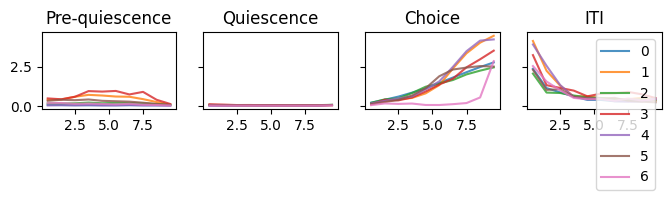

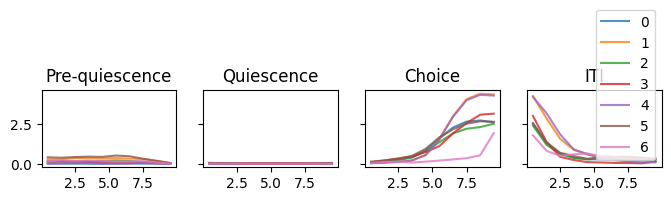

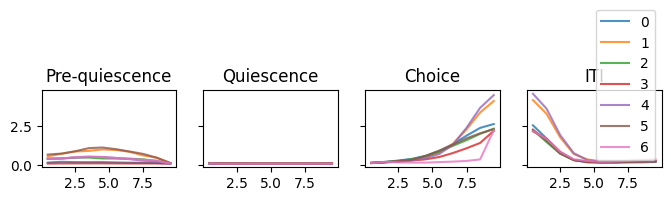

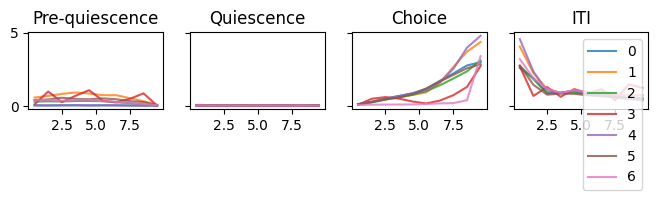

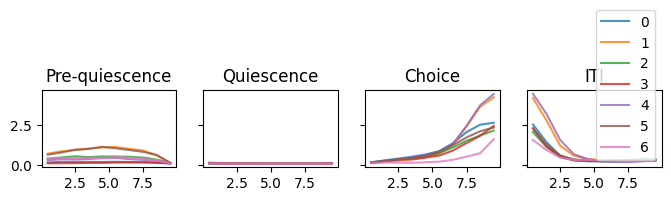

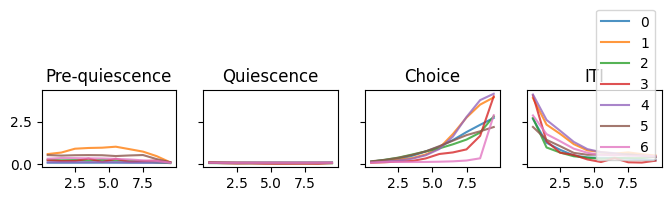

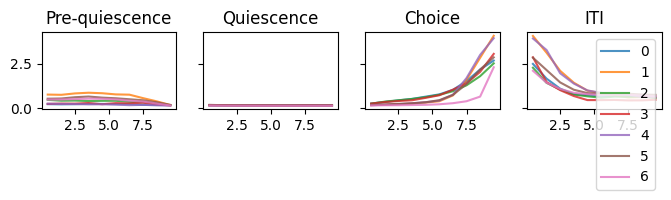

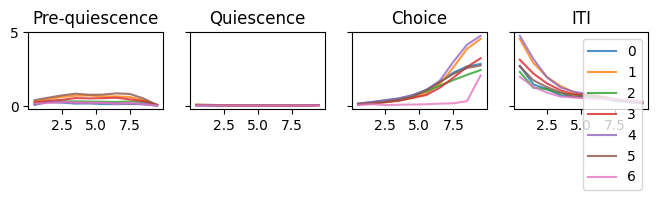

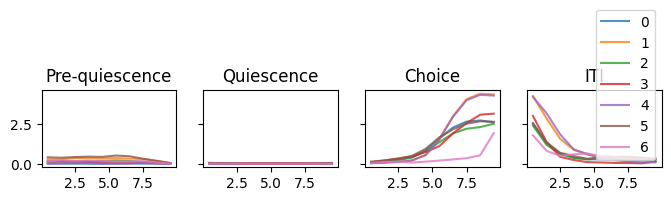

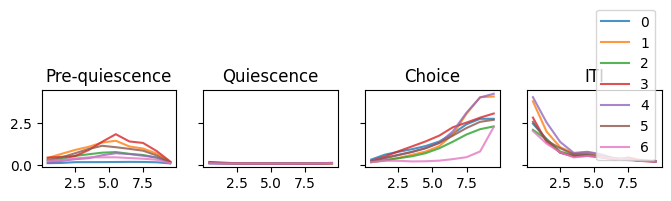

In [102]:
all_binned['y'] = all_binned['cluster'].astype(str) + all_binned['broader_label']
sequence_types = all_binned['cluster'].sort_values().unique()
for m, mat in enumerate(sessions_to_process[:10]):

    mouse_name = mat[0]
    session = mat[1]
    fit_id = str(mouse_name+session)
    
    fig, axs = plt.subplots(1, 4, sharex=False, sharey=True, figsize=(8, 1))

    for s, stype in enumerate(sequence_types):
        # print(stype)
        use_data = all_binned.loc[(all_binned['cluster']==stype) &
                                  (all_binned['mouse_name']==mouse_name)]
        
        for e, epoch in enumerate(['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']):
                epoch_data = use_data.loc[use_data['broader_label']==epoch]
                epoch_wheel = list(epoch_data['binned_wheel'])[0]
                X = np.vstack(epoch_data['binned_wheel'].apply(lambda x: np.abs(np.array(x))).values).mean(axis=0)
                # X = np.vstack(epoch_data['binned_wheel'].apply(lambda x: np.abs(np.array(x))).values)
                axs[e].plot(np.arange(.5, len(X)+.5), X, alpha=.8, label=stype)
                # axs[e].plot(np.arange(.5, np.shape(X)[1]+.5), X.T, alpha=.2, color='blue')
                # axs[e].set_ylim([0, 3])
                axs[e].set_title(epoch)
    plt.legend()
    plt.show()

0


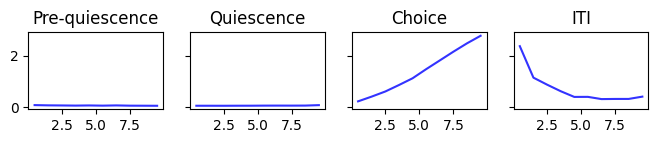

1


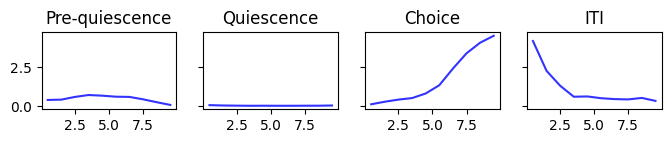

2


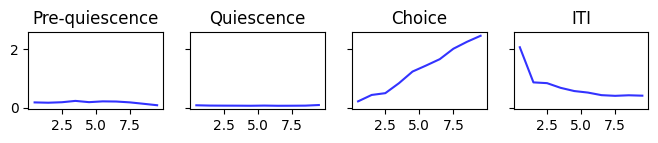

3


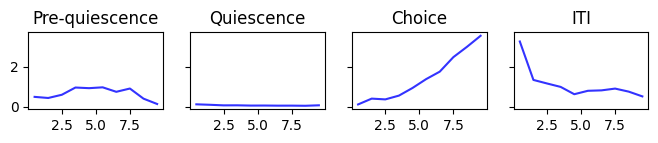

4


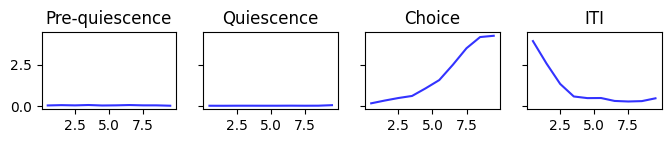

5


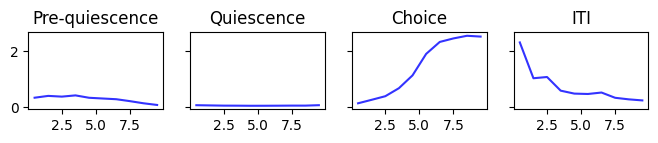

6


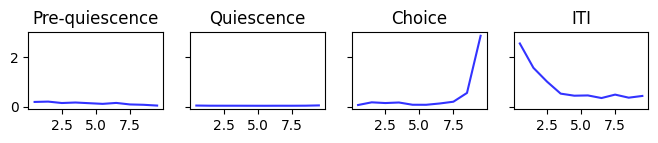

0


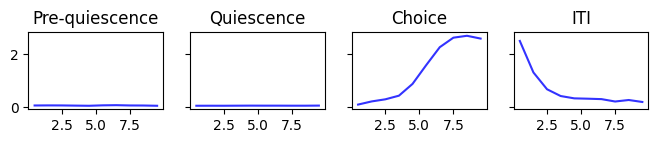

1


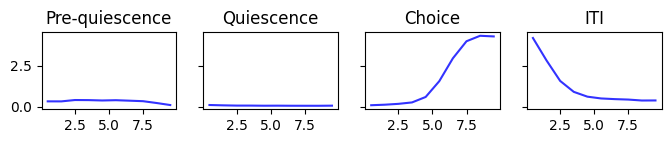

2


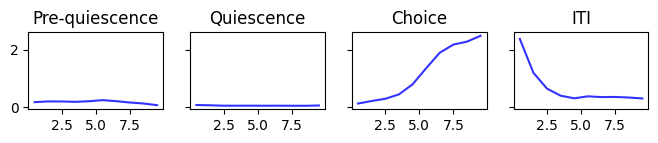

3


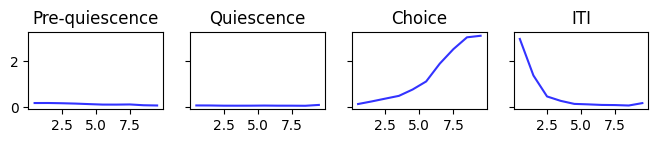

4


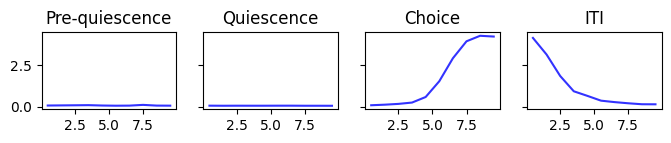

5


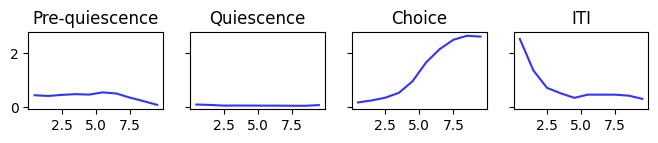

6


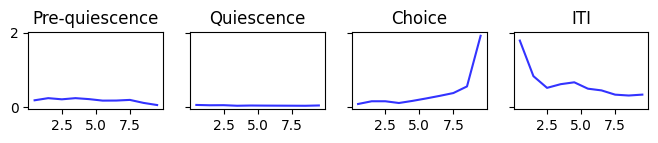

0


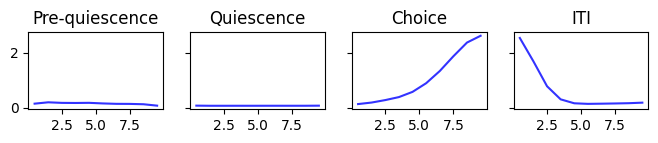

1


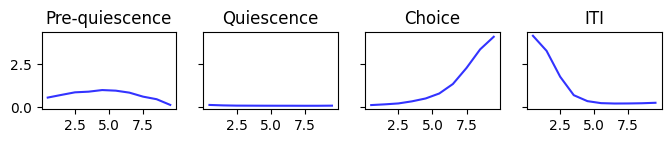

2


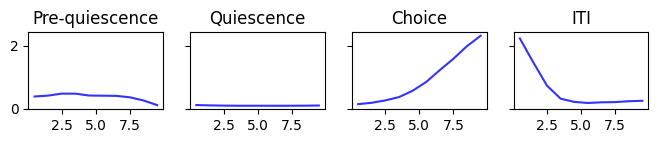

3


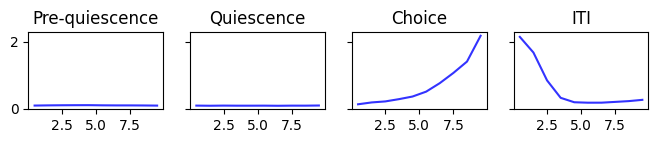

4


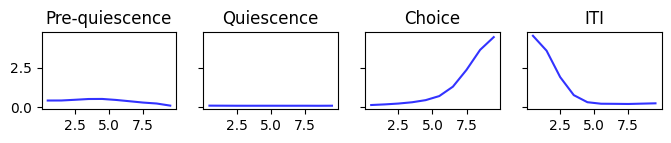

5


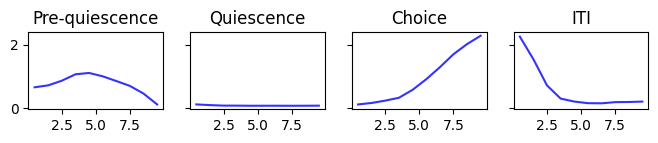

6


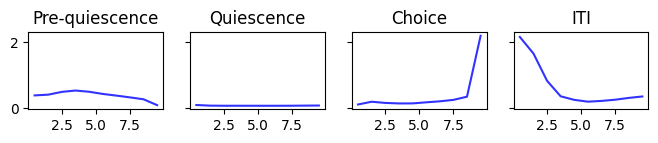

0


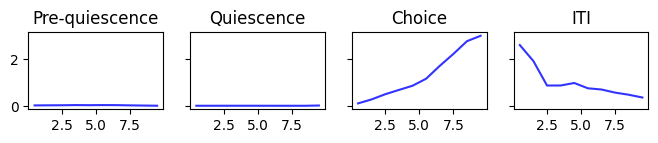

1


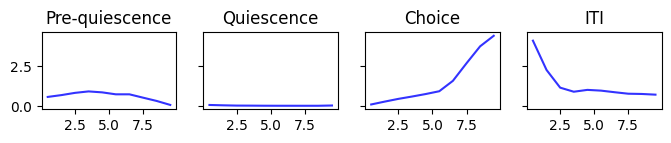

2


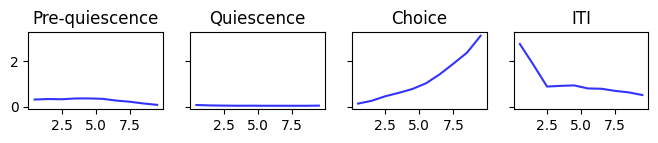

3


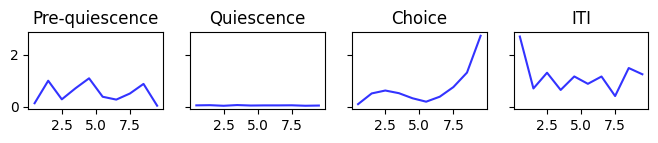

4


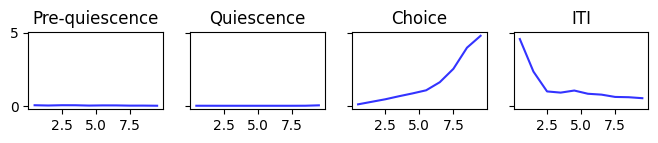

5


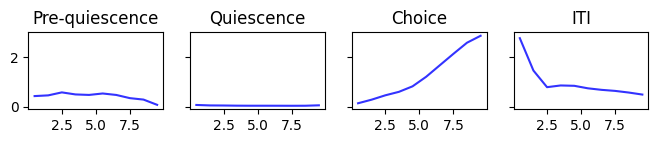

6


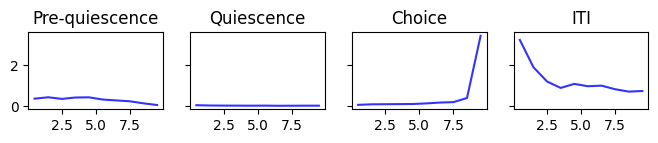

0


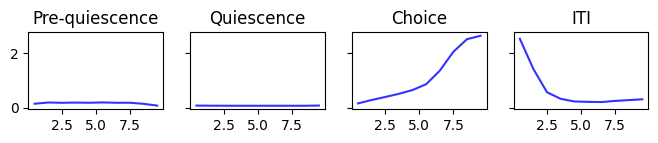

1


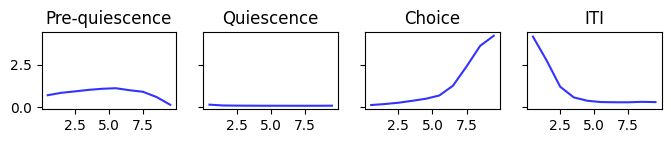

2


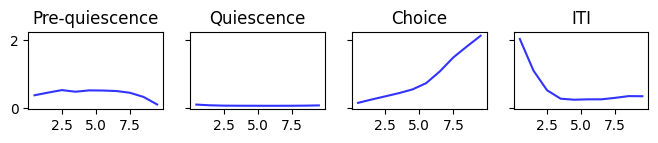

3


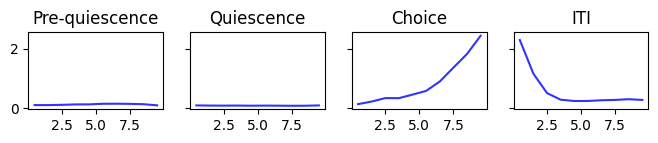

4


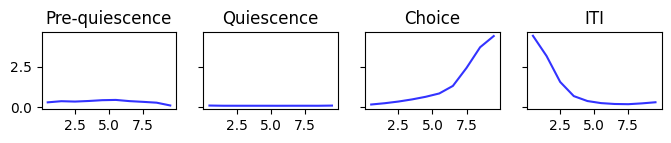

5


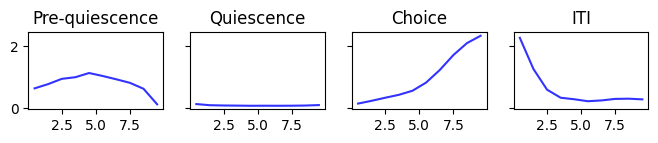

6


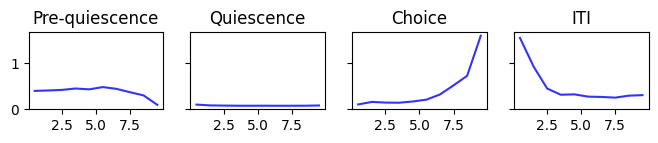

0


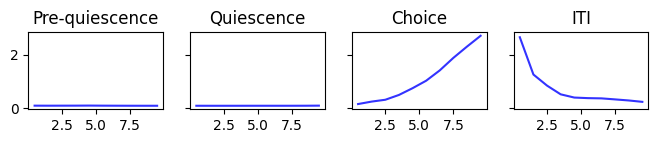

1


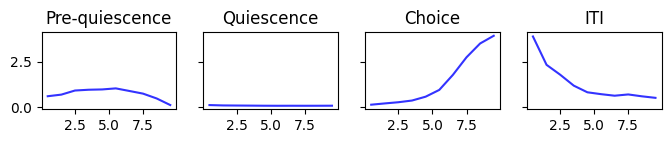

2


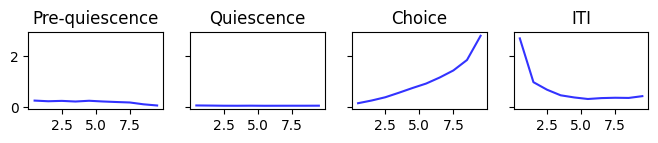

3


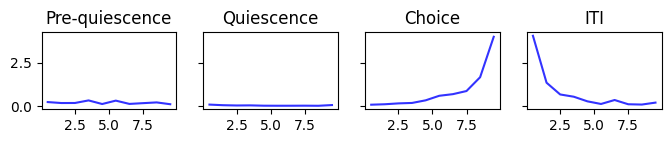

4


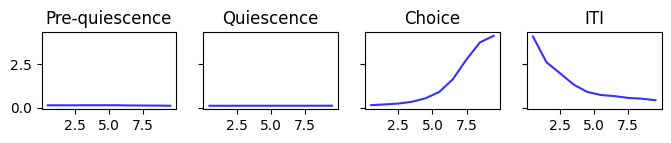

5


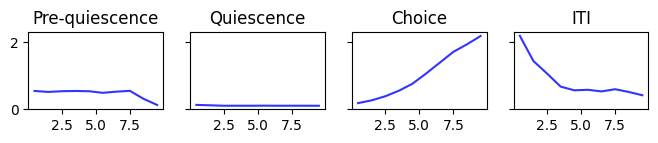

6


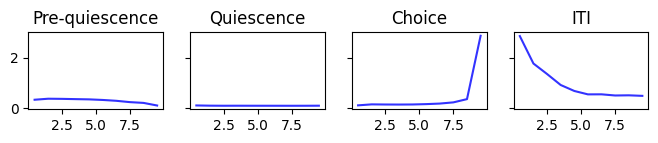

0


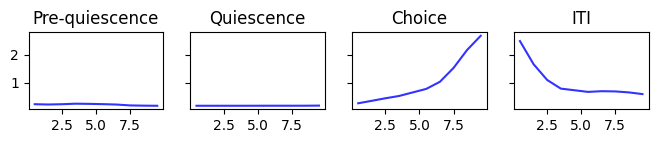

1


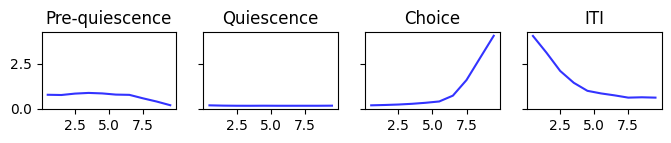

2


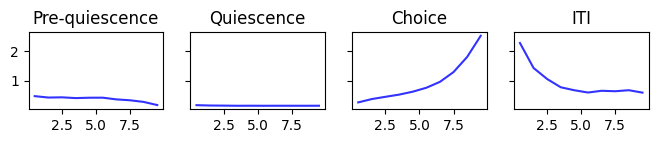

3


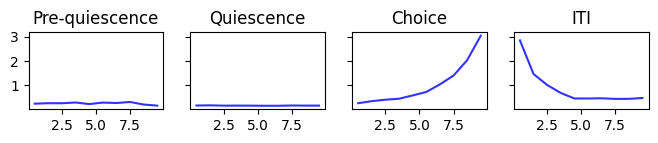

4


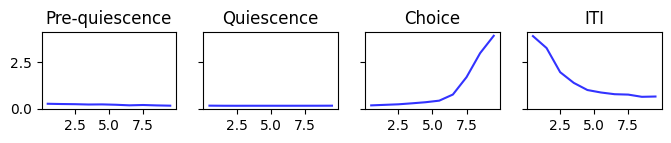

5


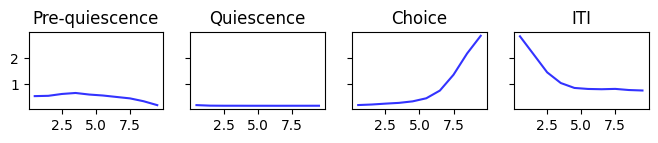

6


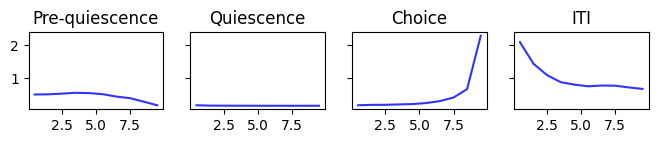

0


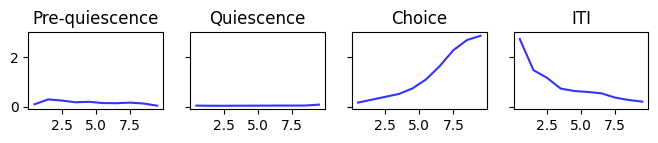

1


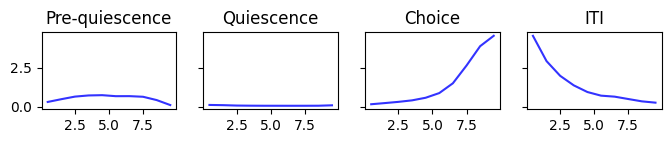

2


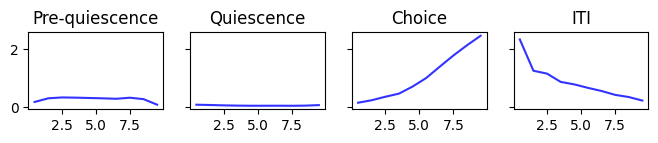

3


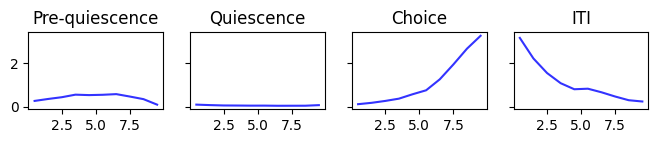

4


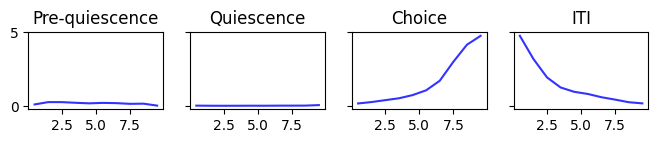

5


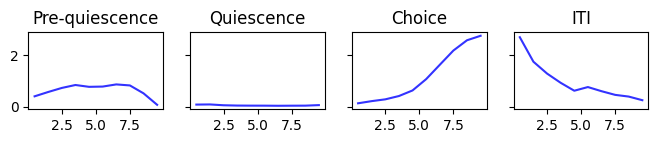

6


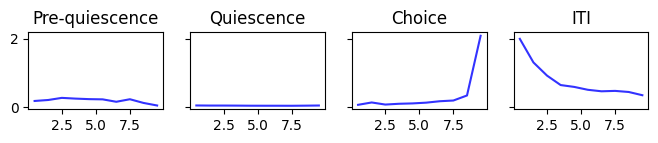

0


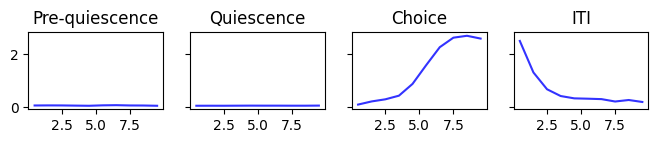

1


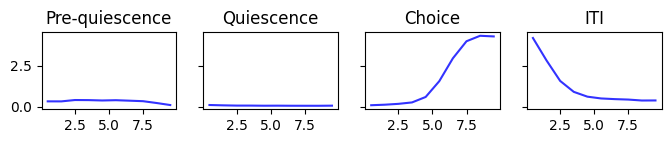

2


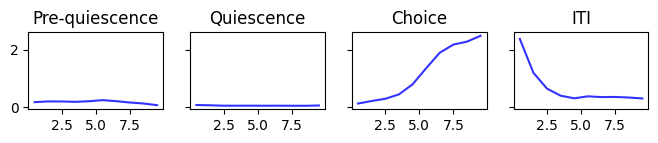

3


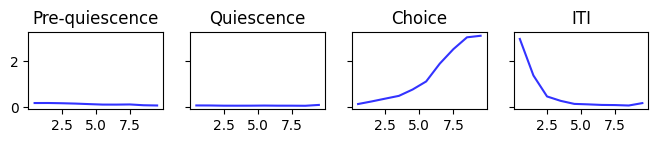

4


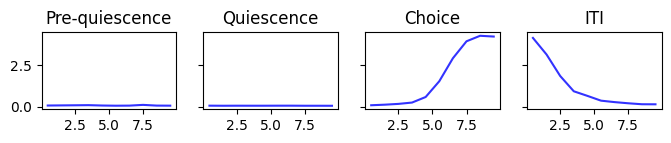

5


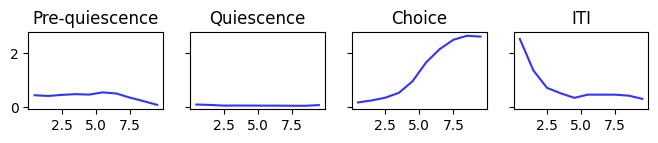

6


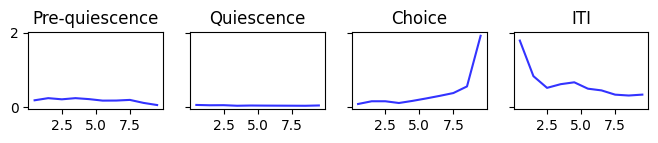

0


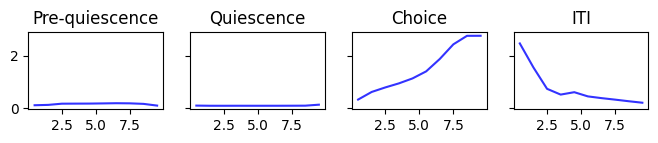

1


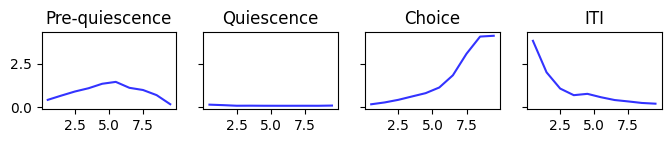

2


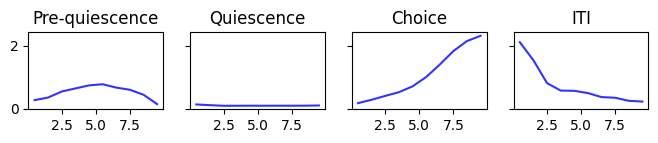

3


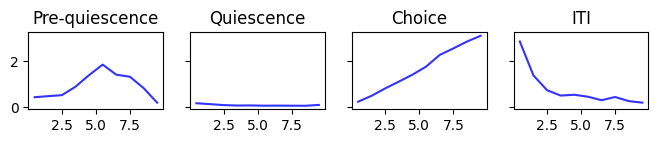

4


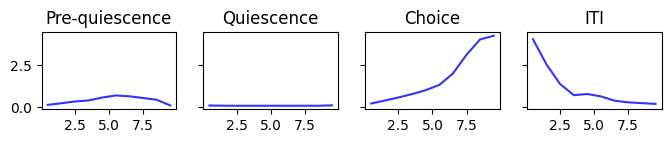

5


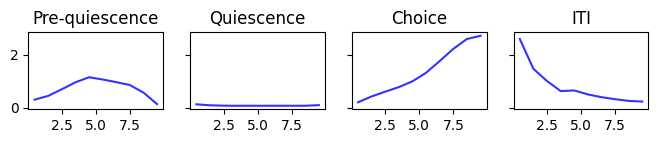

6


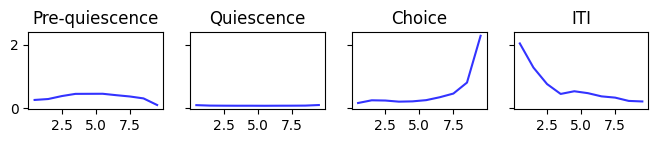

In [98]:
all_binned['y'] = all_binned['cluster'].astype(str) + all_binned['broader_label']
sequence_types = all_binned['cluster'].sort_values().unique()
# len_matrix = 4950
# sequence_types = ['0Quiescence', '1Quiescence', '2Quiescence', '3Quiescence', '4Quiescence', '5Quiescence', '6Quiescence']# all_cos_sim = pd.DataFrame(columns=['epoch', 'type', 'cos_sim', 'shuffle'], index=range(len(sequence_types)*len_matrix))
# sequence_types = ['0Choice', '1Choice', '2Choice', '3Choice', '4Choice', '5Choice', '6Choice']# all_cos_sim = pd.DataFrame(columns=['epoch', 'type', 'cos_sim', 'shuffle'], index=range(len(sequence_types)*len_matrix))
# sequence_types = ['0ITI', '1ITI', '2ITI', '3ITI', '4ITI', '5ITI', '6ITI']# all_cos_sim = pd.DataFrame(columns=['epoch', 'type', 'cos_sim', 'shuffle'], index=range(len(sequence_types)*len_matrix))
# sequence_types = ['0Pre-quiescence', '1Pre-quiescence', '2Pre-quiescence', '3Pre-quiescence', '4Pre-quiescence', '5Pre-quiescence', '6Pre-quiescence']# all_cos_sim = pd.DataFrame(columns=['epoch', 'type', 'cos_sim', 'shuffle'], index=range(len(sequence_types)*len_matrix))
for m, mat in enumerate(sessions_to_process[:10]):

    mouse_name = mat[0]
    session = mat[1]
    fit_id = str(mouse_name+session)
    
    for s, stype in enumerate(sequence_types):
        print(stype)
        use_data = all_binned.loc[(all_binned['cluster']==stype) &
                                  (all_binned['mouse_name']==mouse_name)]
        
        fig, axs = plt.subplots(1, 4, sharex=False, sharey=True, figsize=(8, 1))
        for e, epoch in enumerate(['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']):
                epoch_data = use_data.loc[use_data['broader_label']==epoch]
                epoch_wheel = list(epoch_data['binned_wheel'])[0]
                X = np.vstack(epoch_data['binned_wheel'].apply(lambda x: np.abs(np.array(x))).values).mean(axis=0)
                # X = np.vstack(epoch_data['binned_wheel'].apply(lambda x: np.abs(np.array(x))).values)
                axs[e].plot(np.arange(.5, len(X)+.5), X, alpha=.8, color='blue')
                # axs[e].plot(np.arange(.5, np.shape(X)[1]+.5), X.T, alpha=.2, color='blue')
                # axs[e].set_ylim([0, 3])
                axs[e].set_title(epoch)
                
        plt.show()
            

### Load data directly

In [7]:
results_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/1_HMM_states/'
filename = str(results_path + 'epoch_sequences_10_03-11-2025')
all_sequences = pickle.load(open(filename, 'rb'))


In [8]:
num_samples = 100

/tmp/ipykernel_23001/3062500038.py:8: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:grey'` for the same effect.

  sns.barplot(x='epoch', y='value', hue='Dataset', data=new_df, color='grey',


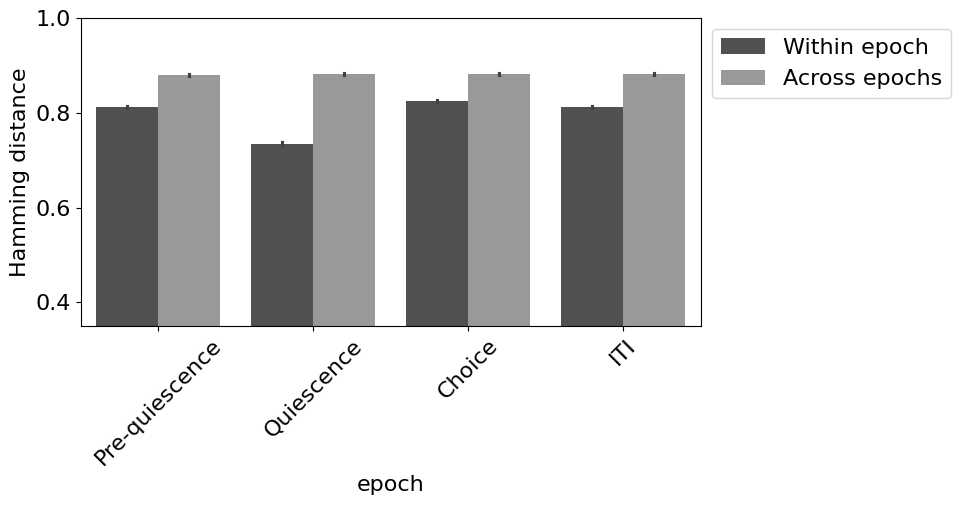

In [29]:

plt.rcParams.update({'font.size': 16})
new_df = pd.melt(all_cos_sim, id_vars=['type', 'epoch'], value_vars=['cos_sim', 'shuffle'])
new_df = new_df.rename(columns={"variable": "Dataset"})
new_df.loc[new_df['Dataset']=='cos_sim', 'Dataset'] = 'Within epoch'
new_df.loc[new_df['Dataset']=='shuffle', 'Dataset'] = 'Across epochs'

plt.figure(figsize=[8, 4])
sns.barplot(x='epoch', y='value', hue='Dataset', data=new_df, color='grey', 
            order=['Pre-quiescence', 'Quiescence', 'Choice', 'ITI'], alpha=.8)
plt.xticks(rotation=45)
plt.ylim([.35, 1])
plt.ylabel('Hamming distance')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

### Calculate per animal

In [11]:
all_sequences['type'] = all_sequences['trial_type'].str.split().str[:2].str.join('')
all_sequences['type'] = all_sequences['trial_type'].str.split().str[:1].str.join('')
all_sequences['y'] = all_sequences['type'] + all_sequences['broader_label']
all_sequences['y'] = all_sequences['broader_label'] 

use_sequences = all_sequences.copy() #.loc[all_sequences['type']=='correct']

num_samples = 100
len_matrix = 4950

sequence_types = use_sequences['y'].unique()
unique_mice = use_sequences['mouse_name'].unique()

cos_sim = pd.DataFrame(columns=['mouse_name', 'epoch', 'cos_sim', 'shuffle'])

for s, stype in enumerate(sequence_types):
    use_data = use_sequences.loc[use_sequences['y']==stype]
    
    mouse_cos_sim = pd.DataFrame(columns=['mouse_name', 'epoch', 'cos_sim', 
                                          'shuffle'], index=range(len(sequence_types)*len_matrix))
    for m, mouse in enumerate(unique_mice):
        mouse_data = use_data.loc[use_data['mouse_name']==mouse]
        shuffle_mouse = use_data.copy()
        
        X = np.vstack(mouse_data['binned_sequence'].apply(lambda x: np.array(x)).values)
        X_final = X[~np.isnan(X).any(axis=1), :].astype(int)
        X_shuffle = np.vstack(shuffle_mouse['binned_sequence'].apply(lambda x: np.array(x)).values)
        X_shuffle_final = X_shuffle[~np.isnan(X_shuffle).any(axis=1), :].astype(int)
        
        if len(X_final) > num_samples:
            # Downsample
            indices = np.random.choice(X_final.shape[0], num_samples, replace=False)  # Random indices
            subsampled_matrix = X_final[indices]
            indices_shuffle = np.random.choice(X_shuffle_final.shape[0], num_samples, replace=False)  # Random indices
            subsampled_matrix_shuffle = X_shuffle_final[indices_shuffle]
                            
            # cos_sim_matrix = cosine_similarity(subsampled_matrix.astype(np.uint8))
            # cos_sim_matrix_shuffle = cosine_similarity(subsampled_matrix_shuffle.astype(np.uint8))
            cos_sim_matrix = distance.pdist(subsampled_matrix.astype(np.uint8), metric='hamming')
            cos_sim_matrix_shuffle = distance.pdist(subsampled_matrix_shuffle.astype(np.uint8), metric='hamming')
            
            # Save results
            mouse_cos_sim['epoch'][s*len_matrix:(s+1)*len_matrix] = stype 
            mouse_cos_sim['mouse_name'][s*len_matrix:(s+1)*len_matrix] = mouse
            mouse_cos_sim['cos_sim'][s*len_matrix:(s+1)*len_matrix] = cos_sim_matrix
            mouse_cos_sim['shuffle'][s*len_matrix:(s+1)*len_matrix] = cos_sim_matrix_shuffle
            
            
            cos_sim = pd.concat([cos_sim, mouse_cos_sim], ignore_index=True)
                
        else:
            print(mouse)

/tmp/ipykernel_23001/1824349412.py:43: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  mouse_cos_sim['epoch'][s*len_matrix:(s+1)*len_matrix] = stype
/tmp/ipykernel_23001/1824349412.py:44: FutureWarning: ChainedAssignmentError: behaviour will c

In [13]:
new_df = pd.melt(cos_sim, id_vars=['mouse_name', 'epoch'], value_vars=['cos_sim', 'shuffle'])
grouped_df = pd.DataFrame(new_df.groupby(['mouse_name', 'epoch', 'variable'])['value'].mean()).reset_index()


/tmp/ipykernel_23001/2940803720.py:9: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:Grey'` for the same effect.

  sns.barplot(x='epoch', y='value', hue='Dataset', data=grouped_df, color='Grey',


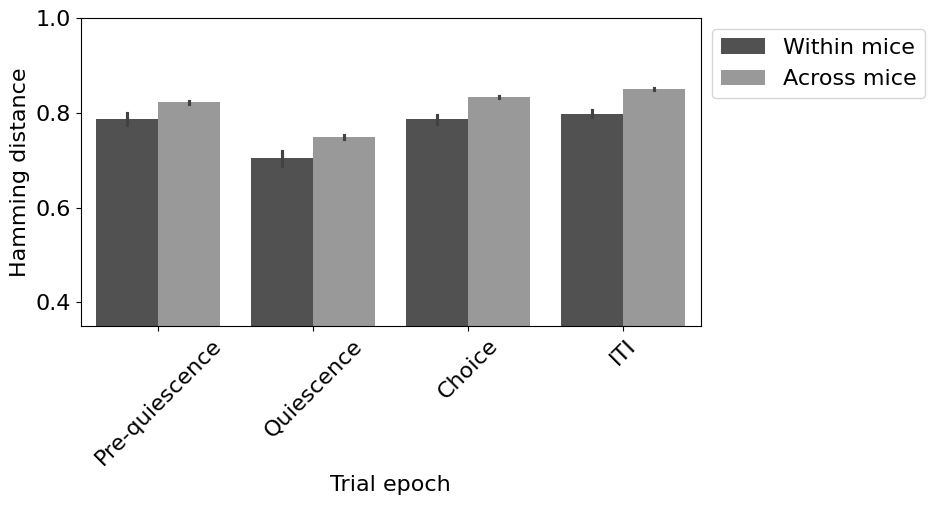

In [26]:
plt.rcParams.update({'font.size': 16})
grouped_df = grouped_df.rename(columns={"variable": "Dataset"})
grouped_df.loc[grouped_df['Dataset']=='cos_sim', 'Dataset'] = 'Within mice'
grouped_df.loc[grouped_df['Dataset']=='shuffle', 'Dataset'] = 'Across mice'

plt.figure(figsize=[8, 4])
# sns.barplot(x='epoch', y='value', hue='variable', data=grouped_df)
# sns.violinplot(x='epoch', y='value', hue='Dataset', data=grouped_df, color='Grey', alpha=.8)
sns.barplot(x='epoch', y='value', hue='Dataset', data=grouped_df, color='Grey', 
            order=['Pre-quiescence', 'Quiescence', 'Choice', 'ITI'], alpha=.8)
plt.xticks(rotation=45)
plt.ylim([.35, 1])
plt.xlabel('Trial epoch')
plt.ylabel('Hamming distance')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 21.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 13.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(87.72222222222221, 0.5, 'Hamming distance')

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 31.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 32.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 27.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 16.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


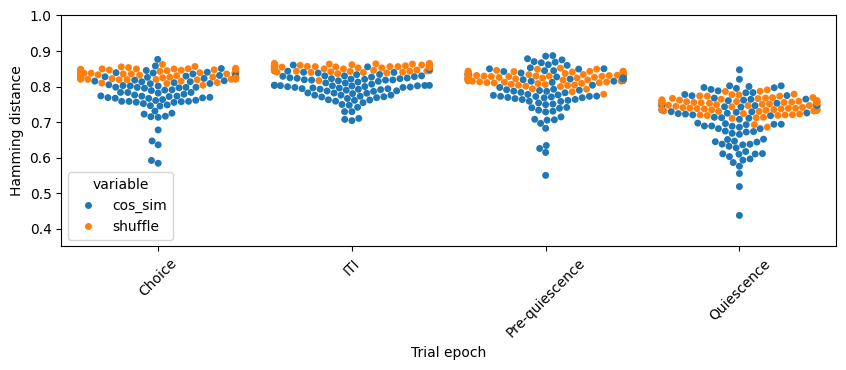

In [25]:

plt.figure(figsize=[10, 3])
# sns.barplot(x='epoch', y='value', hue='variable', data=grouped_df)
sns.swarmplot(x='epoch', y='value', hue='variable', data=grouped_df)
plt.xticks(rotation=45)
plt.ylim([.35, 1])
plt.xlabel('Trial epoch')
plt.ylabel('Hamming distance')

Text(0, 0.5, 'Hamming distance')

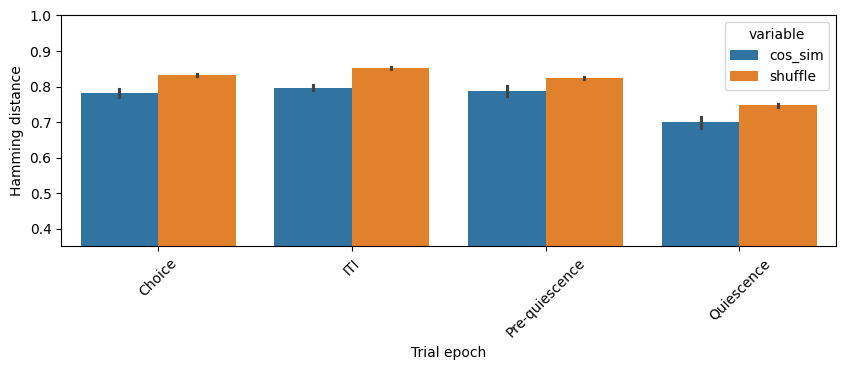

In [26]:

plt.figure(figsize=[10, 3])
# sns.barplot(x='epoch', y='value', hue='variable', data=grouped_df)
sns.barplot(x='epoch', y='value', hue='variable', data=grouped_df)
plt.xticks(rotation=45)
plt.ylim([.35, 1])
plt.xlabel('Trial epoch')
plt.ylabel('Hamming distance')

Text(112.72222222222221, 0.5, 'Hamming distance')

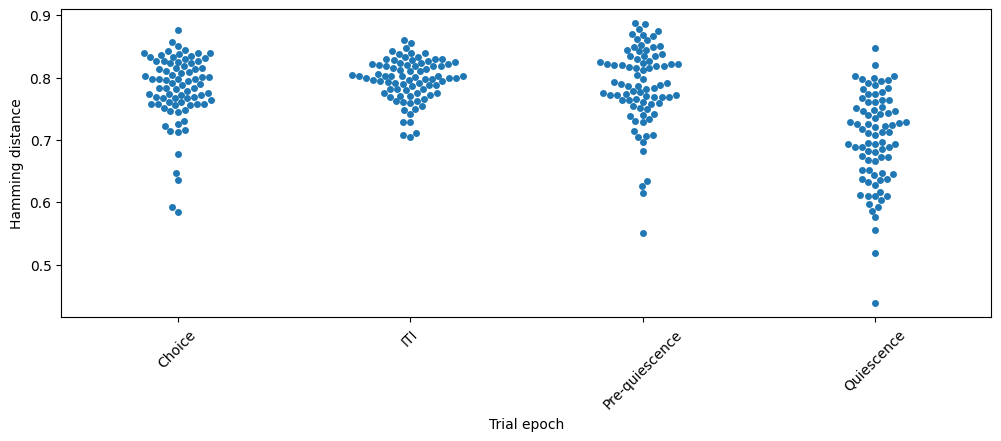

In [27]:

plt.figure(figsize=[12, 4])
sns.swarmplot(x='epoch', y='value',  data=grouped_df.loc[grouped_df['variable']=='cos_sim'])
plt.xticks(rotation=45)
# plt.ylim([.6, 1])
plt.xlabel('Trial epoch')
plt.ylabel('Hamming distance')

([0, 1, 2, 3],
 [Text(0, 0, 'Choice'),
  Text(1, 0, 'ITI'),
  Text(2, 0, 'Pre-quiescence'),
  Text(3, 0, 'Quiescence')])

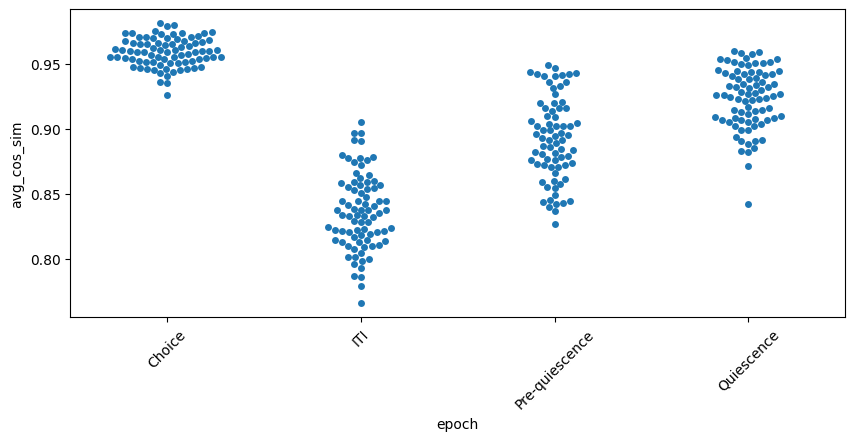

In [75]:
plt.figure(figsize=[10, 4])
sns.swarmplot(x='epoch', y='avg_cos_sim', data=cos_sim)
plt.xticks(rotation=45)
# plt.ylim([.6, 1])